Inteligentne Systemy Wspomagania Decyzji\
Odporna regresja porządkowa\
Informatyka, st. II, semestr 1\
Jakub Kondys, 151839\
Kacper Dąbrowski, 151521

In [1]:
# import bibliotek
import matplotlib.pyplot as plt
from pulp import LpProblem, LpVariable, LpMaximize, lpSum, value, LpStatus, LpAffineExpression, LpMinimize
from typing import Tuple, List
import numpy as np # dla wygody miejscami

### Wczytywanie danych
Numeracja wariantów jak w pliku 0-26. Jednynie przy definicji problemu programowania liniowego numeracja 1-27, jak w pracy z której są.

In [2]:
# wczytane wartości kryteriów z pliku
data_file = "Nuclear waste management.csv"
data = []

with open(data_file, "r") as f:
    f.readline() # pomiń nagłówek
    for line in f:
        nr, c1, c2, c3, c4 = line.strip().split(",")
        data.append((int(nr) - 1, float(c1), float(c2), float(c3), float(c4)))
data[:4] + ["..."] + data[-4:]

[(0, 0.6, 0.93, 0.0, 0.73),
 (1, 0.66, 0.55, 0.45, 0.49),
 (2, 1.0, 0.45, 0.57, 0.5),
 (3, 0.48, 0.87, 0.0, 0.75),
 '...',
 (23, 0.73, 0.03, 1.0, 0.63),
 (24, 0.34, 1.0, 1.0, 1.0),
 (25, 0.71, 0.25, 0.88, 0.67),
 (26, 0.8, 0.06, 1.0, 0.67)]

#### Kryteria

Kryterium 1 - całkowity koszt finansowy, kryterium typu koszt\
Kryterium 2/3 - finansowanie kosztu w okresie $(0, 30)/(30,\infty)$ lat, kryterium typu zysk - chcemy by koszty się zwróciły\
Kryterium 4 - ryzyko poniesienia zbyt wielkich kosztów zanim będą one w stanie być sfinansowane, kryterium typu koszt - ryzyko z pewnością nie jest pozytywne

#### Ranking referencyjny

##### Informacja prefernecyjna na podstawie której oceniane były warianty:
1. Pierwsza grupa: Wydajność produkcji energii elektrycznej wzrośnie w przyszłości. Dodatkowo nie
chcę brać pożyczek. -> Preferujemy $F_1$ - większa wydajność w przyszlości, zatem więcej energii przy takiej samej ilości odpadów, bardzo nie chcemy $F_3$ - kredyt
2. Druga grupa: W skutek wyczerpywania się złóż materiałów radioaktywnych, elektrownie mogą
zacząć korzystać z bardziej ubogich złóż, co przełoży się na zwiększenie ilości odpadów radioak-
tywnych. -> preferujemy $F_3$, i $F_2$ bardziej - opłata od ilości odpadów, chcemy też przechowywać krócej, żeby czasem magazyn się nie wypełnił całkowicie w przyszłośći przy większej ilości odpadów ($S_1>S_2>S_3$).
3. Łącząc wyniki obu grup, preferujemy jak najkrótsze przechowywanie odpadów: $S_1>S_2>S_3$. Preferencje co do planów finansowania wybierzmy z pierwszej grupy - uznajmy, że zupełnie nie chcemy kredytu, a wydajność energii wzrośnie znacząco: $F_1>F_2>>F_3$. Brak informacji o preferencji lokalizacji, zatem: $R_1=R_2=R_3$.

#### Ocena Wariantów
Za pomocą powyższych preferencji, oceniono kolejno 2 pary wariantów, po 1 przydzielonym do osoby oraz 3 pary wariantów wybrane losowo - generator liczb losowych 0-26.

Warianty 13, 16: $13\sim16$, różnią się tylko lokalizacją\
Warianty 14, 25: $25>14$, 14 lepszy plan przechowywania odpadów, ale znacząco gorszy plan finansowy\
Warianty 9, 7:   $9\sim7$, lepszy plan finansowy 9 jest niwelowany przez plan krótszego przechowywania odpadów 7\
Warianty 11, 18: $18>11$, o wiele lepszy plan finansowania\
Warianty 23, 6:  $6>23$, 6 to właściwie wariant idealny

Mamy zatem 2 pary wariantów nierozróżnialnych i 3 pary wariantów w których jeden jest preferowany nad drugi.

In [3]:
# nazwy kryteriów
criterions = ["C1", "C2", "C3", "C4"]

In [4]:
# definicja preferencji i parametrów metody dla konkretnego przykładu
indiff_variants = [(13, 16), (9, 7)] # (x, y) -> x~y, nierozróżnialne
pref_variants = [(25, 14), (18, 11), (6, 23)] # (x, y) -> x>y, preferencje
criterion_directions = ["cost", "gain", "gain", "cost"]
# od 0 do 1 bo wiemy, że dane są znormalizowane do przedziału [0, 1]
# dla liczenia min i max z danych jak w poniższych komentarzach wyniki praktycznie identyczne - zarówno UTA jak i UTAGMS
# datanp = np.array(data)[:, 1:] # data numpy bez numerów wariantów
# min_values = np.min(datanp, axis=0) # minimalne wartości kryteriów
# max_values = np.max(datanp, axis=0) # maksymalne wartości kryteriów
min_values = [0, 0, 0, 0] # minimalne wartości kryteriów
max_values = [1, 1, 1, 1] # maksymalne wartości kryteriów
number_breaks = [1, 1, 1, 1] # liczba punktów przełamania dla funkcji liniowej dla każdego kryterium
eps = 0.001 # mała liczba do ograniczeń nierozróżnialności, o tyle mogą się różnić użyteczności wariantów by stwierdzenie x~y było prawdziwe

In [5]:
def add_monotonicity_constraints(prob: LpProblem, breakpoints: List[float]) -> Tuple[LpProblem, List[List[LpVariable]], List[LpVariable], List[LpVariable]]:
    u_a = [] # zmienne u_i(a_i), gdzie a_i to najgorsza wartość kryterium i
    u_b = [] # zmienne u_i(b_i), gdzie b_i to najlepsza wartość kryterium i
    u_breakpoints = [] # macierz ixj zmienne u_i(x_i^j), gdzie x_i^j to j-ty punkt przełamania dla kryterium i

    # ograniczenia monotoniczności
    for i, dir in enumerate(criterion_directions):
        u_bp = []
        for j, bp in enumerate(breakpoints[i]):
            u_bp.append(LpVariable(name=f"u_{i+1}({bp})", lowBound=0, upBound=1)) # zmienne u_i(x_i^j) wyrażające użyteczność dla każdego kryterium i punktu przełamania

        # dodanie ograniczeń monotoniczności
        if dir == "gain":
            for j in range(len(u_bp) - 1):
                # im większa wartość na kryterium tym większa użyteczność
                prob += u_bp[j] <= u_bp[j + 1], f"Monotonicity_{criterions[i]}_{j}"
            u_a.append(u_bp[0])
            u_b.append(u_bp[-1])
        else:
            for j in range(len(u_bp) - 1):
                # im większa wartość na kryterium tym mniejsza użyteczność
                prob += u_bp[j] >= u_bp[j + 1], f"Monotonicity_{criterions[i]}_{j}"
            u_a.append(u_bp[-1])
            u_b.append(u_bp[0])
        u_breakpoints.append(u_bp)
    return prob, u_breakpoints, u_a, u_b

In [6]:
def add_normalization_constraints(prob: LpProblem, u_a: List[LpVariable], u_b: List[LpVariable]) -> LpProblem:
    # suma nalepszych wartości użyteczności = 1
    prob += lpSum(u_b) == 1, "Sum_of_u_b=1"
    # najgorsze użyteczności = 0
    for i, ua in enumerate(u_a):
        prob += ua == 0, f"u_a_{i+1}=0"
    return prob

In [7]:
def calculate_variant_utility(nr: int, u_breakpoints: List[List[LpVariable]], breakpoints: List[float]) -> Tuple[LpAffineExpression, List[LpVariable]]:
    local_utilities = []
    for i, bp in enumerate(breakpoints):
        u_bp = u_breakpoints[i] # zmienne użyteczności dla punktów przłamania (breakpoints) na kryterium i
        diff = diffs[i] / (len(breakpoints[i]) - 1) # różnica wartości kryterium między punktami kolejnymi przełamania
        val_c = data[nr][i + 1] # wartość kryterium i dla wariantu nr

        for j in range(len(bp) - 1):
            if val_c < bp[j + 1]:
                break
        # (j, j+1) - numery punktów przełamania między którymi należy obliczyć interpolację
        start = j
        end = j + 1
        # użyteczność na kryterium to użyteczność w początkowym punkcie przełamania + interpolacja liniowa między punktami przełamania
        if val_c == bp[j]: # jeśli wartość kryterium jest równa punktowi przełamania to użyteczność jest równa użyteczności w tym punkcie - nie trzeba interpolować
            local_utilities.append(u_bp[start])
        else:
            local_utilities.append(u_bp[start] + (val_c - bp[start]) * (u_bp[end] - u_bp[start]) / diff)
    return lpSum(local_utilities), local_utilities # globalna użyteczność wariantu to suma lokalnych użyteczności


In [8]:
# po to by wygodnie mieć dostęp do zmiennych globalnych użyteczności wariantów, dodadkowo lokalne użyteczności wariantów
def vars_utilities(prob: LpProblem, u_breakpoints: List[List[LpVariable]], breakpoints: List[float]) -> Tuple[LpProblem, List[LpVariable], List[List[LpVariable]]]:
    global_utilities = []
    local_utilities = []
    # dla każdego wariantu dodajemy zmienną globalnej użyteczności
    # oraz ograniczenie wyrażające ją jako sumę lokalnych użyteczności
    for i in range(len(data)):
        global_utilities.append(LpVariable(name=f"U_x{i+1}")) # ograniczenia na przedział [0, 1] niepotrzebne, bo wymuszone przez inne ograniczenia
        g_util, l_utils = calculate_variant_utility(i, u_breakpoints, breakpoints)
        local_utilities.append(l_utils)
        prob += global_utilities[i] == g_util, f"Global_utility_x{i+1}"
    return prob, global_utilities, local_utilities

In [9]:
number_breakpoints = [x + 2 for x in number_breaks] # to co wyżej plus minimum i maksimum
diffs = [max_val - min_val for min_val, max_val in zip(min_values, max_values)] # różnice między wartościami maksymalnymi i minimalnymi dla każdego kryterium
breakpoints = []

for j, nb in enumerate(number_breakpoints):
    bp = []
    for i in range(nb):
        bp.append(min_values[j] + i * diffs[j] / (nb - 1)) # punkty przełamania dla funkcji liniowej na kryterium j
    breakpoints.append(tuple(bp))

# breakpoints

# UTA

## Definicja problemu

Problem jest zdefiniowany następująco:
$$\max \quad \varepsilon$$
Ograniczenia preferencji:
$$U(x_{26})\ge U(x_{15}) + \varepsilon$$
$$U(x_{19})\ge U(x_{12}) + \varepsilon$$
$$U(x_{7})\ge U(x_{24}) + \varepsilon$$
$$U(x_{14})= U(x_{17})$$
$$U(x_{10})= U(x_{8})$$
Ograniczenia monotoniczności:
$$u_{C_1}(1) < u_{C_1}(0.5) < u_{C_1}(0)$$
$$u_{C_2}(0) < u_{C_2}(0.5) < u_{C_2}(1)$$
$$u_{C_3}(0) < u_{C_3}(0.5) < u_{C_3}(1)$$
$$u_{C_4}(1) < u_{C_4}(0.5) < u_{C_4}(0)$$
Ograniczenia normalizacji:
$$u_{C_1}(0) + u_{C_2}(1) + u_{C_3}(1) + u_{C_4}(0) = 1$$
$$u_{C_1}(1) = 0$$
$$u_{C_2}(0) = 0$$
$$u_{C_3}(0) = 0$$
$$u_{C_4}(1) = 0$$
Oprócz wszystkich wymaganych w UTA ograniczeń dodano ograniczenie na maksymalną użyteczność każdego kryterium, która powinna wynosić co najmniej 0.1 (treść zadania). Czyli $$ \sum_{i=1}^{n}u_i\left(\beta_i\right) \ge 0.1$$ gdzie $\beta_i$ to naljepsza wartość na kryterium $i$

In [10]:
prob = LpProblem("UTA", LpMaximize)
epsilon = LpVariable("epsilon", lowBound=None, upBound=None) # maksymalizowana zmienna

u_a = None # tablica zmiennych u_i(a_i), gdzie a_i to najgorsza wartość kryterium i
u_b = None # tablica zmiennych u_i(b_i), gdzie b_i to najlepsza wartość kryterium i
u_breakpoints = None # macierz ixj zmienne u_i(x_i^j), gdzie x_i^j to j-ty punkt przełamania dla kryterium i
global_utilities = None # tablica użyteczności globalnych dla każdego wariantu
local_utitlites = None # macierz ixj użyteczności lokalnych dla każdego wariantu i oraz kryterium j

# funkcja celu
prob += epsilon, "Maximize_epsilon" # maksymalizowana zmienna epsilon + suma najgorszych użyteczności

# ograniczenia monotoniczności
prob, u_breakpoints, u_a, u_b = add_monotonicity_constraints(prob, breakpoints)

# ograniczenia normalizacji
prob = add_normalization_constraints(prob, u_a, u_b)

# ograniczenia wynikające z preferencji decydenta

# ograniczenia preferencji
prob, global_utilities, local_utitlites = vars_utilities(prob, u_breakpoints, breakpoints) # zmienne globalnych użyteczności dla każdego wariantu
for i, (x, y) in enumerate(pref_variants):
    prob += global_utilities[x] >= global_utilities[y] + epsilon, f"Preference_{x+1}_over{y+1}" # x>y

# ograniczenia nierozróżnialności
for i, (x, y) in enumerate(indiff_variants):
    # nie wiem czy == zadziała dobrze z epsilonem w pulpie, więc używam po prostu 2 relacje, przynajmniej widać co się dzieje
    prob += global_utilities[x] - global_utilities[y] <= eps, f"Indifference_{x+1}_over{y+1}_1" # x~y
    prob += global_utilities[x] - global_utilities[y] >= -eps, f"Indifference_{y+1}_over{x+1}_2" # y~x

# ograniczenie wynikające z zadania
for i, ub in enumerate(u_b):
    prob += ub >= 0.1, f"u_{i+1}_b>=0.1"

# prob

##### Czy problem rozwiązywalny i wartość funkcji celu

In [11]:
prob.solve()

# Print results
print(f"Status: {LpStatus[prob.status]}")
# print("\nOptimal Solution:")
# for var in prob.variables():
#     print(f"{var.name} = {value(var)}")

print("\nObjective value:", value(prob.objective))

Status: Optimal

Objective value: 0.15004762


#### Użyteczności cząstkowe i globalne wszystkich wariantów

In [12]:
# importy do wykresów
import pandas as pd # wyświetlanie wyników w formie tabeli

In [13]:
lu_values = []
for i, l_utils in enumerate(local_utitlites):
    lu_values.append([value(lu) for lu in l_utils] + [global_utilities[i].value()])
df = pd.DataFrame(lu_values, columns=[f"u_{i+1}" for i in range(len(criterions))] + ["U"])
df.index = [f"x_{i+1}" for i in range(len(data))]
df.index.name = "Warianty"
df.columns.name = "Kryteria"

# pokaż tabelę z użytecznościami lokalnymi
df

Kryteria,u_1,u_2,u_3,u_4,U
Warianty,,,,,
x_1,0.482857,0.096167,0.000000,0.000,0.579024
x_2,0.410429,0.075357,0.176786,0.002,0.664571
x_3,0.000000,0.065357,0.196429,0.000,0.261786
x_4,0.603571,0.092881,0.000000,0.000,0.696452
x_5,0.458714,0.058095,0.196429,0.000,0.713238
x_6,0.265571,0.039214,0.196429,0.000,0.501214
x_7,0.603571,0.094524,0.000000,0.000,0.698095
x_8,0.434571,0.063905,0.196429,0.000,0.694905
x_9,0.422500,0.043571,0.196429,0.000,0.662500


#### Ranking wszystkich wariantów i ich użyteczności globalne

In [14]:
# globalne użyteczności wariantów
gu = np.array([value(gu) for gu in global_utilities])
# [::-1] - sortowanie malejąco
sorted_indices = np.argsort(gu)[::-1] # posortowane indeksy wariantów według użyteczności globalnej
places = np.zeros(len(gu)) # miejsca wariantów

current_place = 1
current_utility = float("inf")
for i, curr in enumerate(sorted_indices):
    util = gu[curr]
    if util != current_utility:
        current_place = i + 1
        current_utility = util
    places[i] = current_place

table = np.vstack((places, sorted_indices,  gu[sorted_indices]))

df = pd.DataFrame(table.T, columns=["Miejsce", "Wariant", "Użyteczność"]).astype({'Miejsce': 'int', 'Wariant': 'int', 'Użyteczność': 'float'})
df.set_index("Miejsce", inplace=True)

df

,Wariant,Użyteczność
Miejsce,,
1,24,0.900000
2,22,0.726214
3,4,0.713238
4,12,0.701929
5,15,0.700833
6,18,0.698643
7,6,0.698095
8,10,0.696881
9,3,0.696452


#### Wykresy

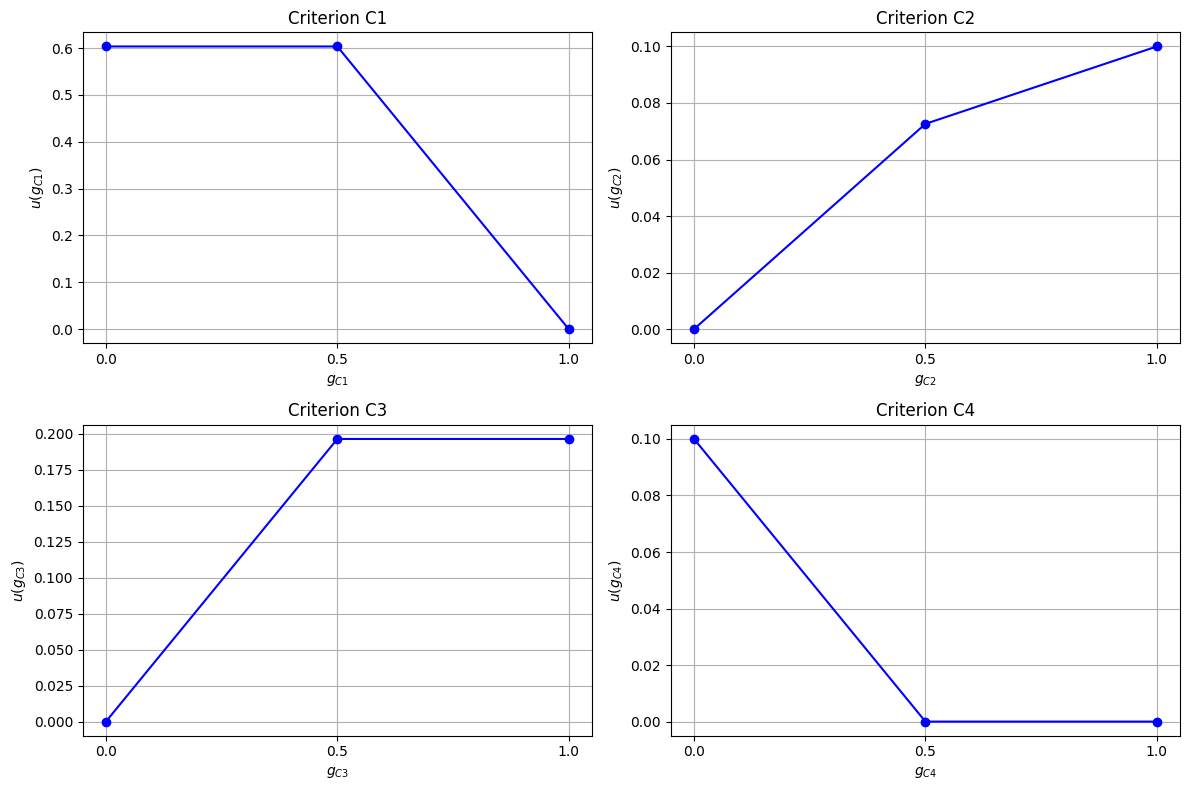

In [15]:
# wykres dla każdego kryterium
# %matplotlib inline

# po 2 wykresy na wiersz
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs = axs.flatten()

for i, u_b in enumerate(u_breakpoints):
    criterion = criterions[i]
    args = [bp for bp in breakpoints[i]]
    values = [value(u_b[j]) for j in range(len(u_b))]
    axs[i].plot(args, values, marker='o', linestyle='-', color='b', label=f"$u(g_{criterion})$")
    axs[i].set_title(f"Criterion {criterions[i]}")
    axs[i].set_xlabel(f"$g_{{{criterion}}}$")
    axs[i].set_ylabel(f"$u(g_{{{criterion}}})$")
    axs[i].set_xticks(args)
    axs[i].grid(True)

plt.tight_layout()
plt.show()

### Podsumowanie

Wyniki zgadzają się z informacją preferencyjną, znaleziono rozwązanie dopuszczale i $\varepsilon^* > 0$ - rzeczywiście dla par wariantów. Warianty preferowane mają wyższą wartość użyteczności i są widocznie wyżej w rankingu niż warianty niepreferowane. Warianty nierozróżnialne z kolei różnią się od siebie o maksymalnie $\varepsilon = 0.001$ (arbitralnie mała wartość - próg nierozróżnialności, nie mylić z funkcją celu) i są obok siebie w rankingu. Jednakże żadna z tych par nie ma tego samego miejsca - nie jest to niespodziewane, w końcu nie minimalizowaliśmy różnicy ich wartości i zastosowaliśmy próg nierozróżnialności $\varepsilon$.

Analizując przykładowe warianty niereferencyjne:

- 3, 4, 5 - Różnią się jedynie planami finansowymi (kolejno $F_1, F_2, F_3$) Widać, że preferencja decydenta nie została zachowana częściowo, warianty są w rankingu w kolejności $4>3>5$, $F_2$ zostało wybrane ponad $F_1$. Jednak zbiór par warniantów referencyjnych był dosyć mały. Gdyby podać więcej wariantów referencyjnych, możliwe, że ranking odwzorowywał preferencje jeszcze lepiej.
Bardzo dobrze jednak odwzorowano preferencję mówiącą o tym, że najmniej preferujemy plan finansowy $F_3$ - ostatnie 6 wariantów w rankingu go używa.
- 3, 12, 21 - Różnią się jedynie planami przechowywania (kolejno $S_1, S_2, S_3$). Ich kolejność w rankingu to $12>3>21$, analogiczna sytuacja co powyżej. Dodatkowo jest to najpewniej skutkiem zerowej liczby par wariantów referencyjnych, w których przeważyłby jednynie plan przechowywania. Podobie jak wyżej, więcej wariantów referencyjnych (najlepiej przemyślanie wybranych by jak najlepiej pokazać preferencje decydenta) powinno poprawić sytuację.

\
Najlepiej wypadła strategia wariantu 24 - $S_3, R_3, F_1$\
Najgorzej z kolei strategia wariantu 2 - $S_1, R_1, F_3$

Wpływ kryterium 4 jest minimalny - tak mały jak pozwalają na to ograniczenia. Kryteria 2 oraz 3 wykazują widoczny wpływ na wynik, jednak to kryterium 1 ma największą rolę w stwierdzaniu rezultatu - maksymalna użyteczność aż 0.6.

# $\text{UTA}^{\text{GMS}}$
W tej metodzie punkty przełamania stanowią wartości kryteriów wariantów. Przy jej pomocy można znajdywać relację możliwej preferencji oraz relację koniecznej preferencji poprzez dodawanie do problemu następujących ograniczeń:
- do sprawdzenia relacji koniecznej preferencji wariantu $a$ nad $b$ sprawdzamy czy dodanie warunku
$$U(b) \ge U(a) + \varepsilon$$
generuje sprzeczność. Wtedy jesteśmy w stanie stwierdzić, że nie istnieje funkcja dla której wariant $b$ jest ściśle prefereowany nad $a$, więc relacja przeciwna $a$ preferowany nad $b$ zawsze zachodzi.
- do sprawdzenia relacji możliwej preferencji wariantu $a$ nad $b$ sprawdzamy czy dodanie warunku
$$U(a) \ge U(b)$$
zachodzi. Wtedy ta relacja jest możliwa dla co najmniej jednej funkcji.

In [16]:
# punkty przełamania to w tym przypadku wartości kryteriów dla wariantów

breakpoints = [[] for _ in range(len(criterions))] # lista punktów przełamania dla każdego kryterium

for i, vals in enumerate(data):
    for j in range(1, len(vals)):
        breakpoints[j - 1].append(vals[j])

# posortowane punkty przełamania bez powtórzeń - nie chcemy niepotrzebnie dodawać zmiennych i ograniczeń
breakpoints_sorted = [sorted(set(b)) for b in breakpoints]

# breakpoints_sorted

In [17]:
# wykorzystuje funkcje pomocnicze z sekcji UTA

prob = LpProblem("UTAGMS", LpMaximize)
epsilon = LpVariable("epsilon", lowBound=None, upBound=None) # maksymalizowana zmienna

u_a = None # tablica zmiennych u_i(a_i), gdzie a_i to najgorsza wartość kryterium i
u_b = None # tablica zmiennych u_i(b_i), gdzie b_i to najlepsza wartość kryterium i
u_breakpoints = None # macierz ixj zmienne u_i(x_i^j), gdzie x_i^j to wartość j-tego wariantu dla kryterium i
# u_breakpoints_sorted = None # macierz ixj zmienne u_i(x_i^j), gdzie x_i^j to wartość j-tego wariantu dla kryterium i, gdzie warianty są uporządkowane wg. użyteczności na kryterium
global_utilities = None # tablica użyteczności globalnych dla każdego wariantu
local_utitlites = None # macierz ixj użyteczności lokalnych dla każdego wariantu i oraz kryterium j

# funkcja celu
prob += epsilon, "Maximize_epsilon" # maksymalizowana zmienna epsilon + suma najgorszych użyteczności

# ograniczenia monotoniczności
prob, u_breakpoints, _, _ = add_monotonicity_constraints(prob, breakpoints_sorted)

u_a_vals = [min_values[i] if criterion_directions[i] == "gain" else max_values[i] for i in range(len(criterions))]
u_b_vals = [max_values[i] if criterion_directions[i] == "gain" else min_values[i] for i in range(len(criterions))]

u_a = []
u_b = []
for i in range(len(criterions)):
    ua = LpVariable(name=f"u_a_{i+1}")
    ub = LpVariable(name=f"u_b_{i+1}")
    u_a.append(ua)
    u_b.append(ub)

# ograniczenia normalizacji
prob = add_normalization_constraints(prob, u_a, u_b)

# ograniczenia na użyteczność wariantów(breakpointów) na kryteriach - między największą możliwą, a najmniejszą możliwą użytecznością na kryterium
for i, u_bp in enumerate(u_breakpoints):
    for bp in u_bp:
        prob += bp >= u_a[i], f"{bp.name}>=u_a_{i+1}"
        prob += bp <= u_b[i], f"{bp.name}<=u_b_{i+1}"

# ograniczenia wynikające z preferencji decydenta

# ograniczenia preferencji
prob, global_utilities, local_utitlites = vars_utilities(prob, u_breakpoints, breakpoints_sorted) # zmienne globalnych użyteczności dla każdego wariantu
for i, (x, y) in enumerate(pref_variants):
    prob += global_utilities[x] >= global_utilities[y] + epsilon, f"Preference_{x+1}_over{y+1}" # x>y

# ograniczenia nierozróżnialności
for i, (x, y) in enumerate(indiff_variants):
    # nie wiem czy == zadziała dobrze z epsilonem w pulpie, więc używam po prostu 2 relacje, przynajmniej widać co się dzieje
    prob += global_utilities[x] - global_utilities[y] <= eps, f"Indifference_{x+1}_over{y+1}_1" # x~y
    prob += global_utilities[x] - global_utilities[y] >= -eps, f"Indifference_{y+1}_over{x+1}_2" # y~x

# ograniczenie wynikające z zadania
for i, ub in enumerate(u_b):
    prob += ub >= 0.1, f"u_{i+1}_b>=0.1"

# prob


##### Sprawdzenie kompatybilności, wartość funkcji celu

In [18]:
prob.solve()

# Print results
print(f"Status: {LpStatus[prob.status]}")
# print("\nOptimal Solution:")
# for var in prob.variables():
#     print(f"{var.name} = {value(var)}")

print("\nObjective value:", value(prob.objective))

Status: Optimal

Objective value: 0.75


Problem jest rozwązywalny oraz $\varepsilon^* > 0$. Istnieje model kompatybilny z preferencjami decydenta.

##### Znajdowanie relacji możliwych i koniecznych.

In [19]:
# relacje w formie (a, b) -> a>b
necessary_relations = []
possible_relations = []

# znajdowanie relacji koniecznych - brute force
for a in range(len(data)):
    for b in range(a+1, len(data)):
        dummy_prob = prob.copy()
        # sprawdzanie czy jest w stanie zajść relacja b>a - jeśli nie to znaczy, że prawdziwa jest relacja konieczna a>=b
        dummy_prob += global_utilities[b] >= global_utilities[a] + epsilon, f"Dummy_utility_{b+1}_over{a+1}"
        dummy_prob.solve()
        if LpStatus[dummy_prob.status] == "Infeasible" or value(epsilon) <= 0:
            necessary_relations.append((a, b))
        # relacja w drugą stronę
        dummy_prob = prob.copy()
        dummy_prob += global_utilities[a] >= global_utilities[b] + epsilon, f"Dummy_utility_{a+1}_over{b+1}"
        dummy_prob.solve()
        if LpStatus[dummy_prob.status] == "Infeasible" or value(epsilon) <= 0:
            necessary_relations.append((b, a))

# znajdowanie relacji możliwych - brute force, bezwarunkowe dodanie gdy występuje relacja konieczna
for a in range(len(data)):
    for b in range(len(data)):
        if a == b:
            continue
        dummy_prob = prob.copy()
        # konieczność implikuje możliwość
        if (a, b) in necessary_relations:
            possible_relations.append((a, b))
            continue
        # sprawdzanie czy jest w stanie zajść relacja a>=b - jeśli tak to znaczy, że prawdziwa jest relacja możliwa a>=b
        dummy_prob += global_utilities[a] >= global_utilities[b], f"Dummy_utility_{a+1}_over{b+1}"
        dummy_prob.solve()
        if LpStatus[dummy_prob.status] != "Infeasible" and value(epsilon) >= 0:
            possible_relations.append((a, b))

##### Liczba znalezionych relacji koniecznych i możliwych

In [20]:
print(f"nr necessary relations: {len(necessary_relations)} nr possible relations: {len(possible_relations)}")
print(f"maximum possible relations: {len(data)**2 - len(data)}")

nr necessary relations: 7 nr possible relations: 702
maximum possible relations: 702


##### Relacja konieczne

In [21]:
necessary_relations

[(6, 23), (18, 11), (11, 20), (17, 14), (25, 14), (17, 26), (18, 20)]

Wszystkie pary wariantów dla których określono preferencje jednego nad drugim znajdują się również w relacjach koniecznych preferencji z tym samym kierunkiem preferencji. Między parami dla których określono, że są nie porównywalne nie zachodzą relacje konieczne preferencji.

Relacje możliwe preferencji zachodzą dla każdej pary wariantów, zatem przestrzeń dopuszczalnych funkcji użyteczności jest dość spora. Zapewne relacje decydenta są zbyt ogólne, by jakaś relacja możliwa preferencji nie była osiągalna - potwierdza to również stosunkowo mała ilość relacji koniecznych.

#### Rysowanie diagramu Hassego

In [22]:
num_variants = len(data) # liczba wariantów
m_start = np.zeros((num_variants, num_variants), dtype=int) # macierz relacji koniecznych
nr_no_transitive = [x for x in necessary_relations]

for (a, b) in necessary_relations:
    for r in necessary_relations:
        if b == r[1] and (a, r[0]) in necessary_relations:
            nr_no_transitive.remove((a, b))

for a, b in nr_no_transitive:
    m_start[a][b] = 1 # a>=Nb

m = m_start.copy()

groups = [] # grupy - wierzchołki (node-y) w grafie
finished = [] # tablica do oznaczania zakończonych wariantów

# szuka kolejno grup - niezdominowane warianty dla aktualnej iteracji, które mają takie same relacje w m_start
# kolejne grupy będą nie wyżej w hierarchii niż poprzednie - dlatego w komórce niżej taki warunek sample_variants_to_group[a] < i
while len(finished) < num_variants:
    sum_col = np.sum(m, axis=0) # liczba wariantów które domunują wariant
    non_dominated = np.where(sum_col == 0)[0] # warianty niedominowane
    non_dominated = np.delete(non_dominated, np.where(np.isin(non_dominated, finished))[0]) # usunięcie zakończonych wariantów
    if np.sum(non_dominated) == 0: # jeśli nie ma niedominowanych to koniec
        break
    while non_dominated.size > 0:
        # dla każdego wariantu niedominowanego
        curr_group = [non_dominated[0]]
        # pierwszy wariant z grupy
        j = non_dominated[0]
        for i in range(1, len(non_dominated)):
            # potencjalny wariant do grupy
            k = non_dominated[i]
            # jeśli k ma takie same relacje w m_start co j to dodaj do grupy
            if np.array_equal(m_start[k], m_start[j]) and np.array_equal(m_start[:, k], m_start[:, j]):
                curr_group.append(k)
        for i in curr_group:
            m[i,:] = 0
            m[:,i] = 0
            finished.append(i)
        non_dominated = np.delete(non_dominated, np.where(np.isin(non_dominated, curr_group))[0])
        groups.append(curr_group)

sample_variants_to_group = {}
for i, group in enumerate(groups):
    sample_variants_to_group[group[0]] = i

In [23]:
from graphviz import Digraph

# dla każdej grupy conkatenacja stringów z numerów wariantów jakie należą do grupy
group_labels = []
edges = []
for i, group in enumerate(groups):
    group_str = " ~ ".join([f"{x}" for x in group])
    group_labels.append(group_str)

for i, group in enumerate(groups):
    sample_variant = group[0]
    for (a, b) in nr_no_transitive:
        if sample_variant == b and a in sample_variants_to_group.keys() and sample_variants_to_group[a] < i:
            second_group = sample_variants_to_group[a]
            edges.append((group_labels[second_group], group_labels[i]))


dot = Digraph(comment='Diagram Hassego', engine='dot')

for label in group_labels:
    dot.node(label)

for edge in edges:
    dot.edge(edge[0], edge[1])

dot.render('hasse_diagram', format='png', cleanup=True)


'hasse_diagram.png'

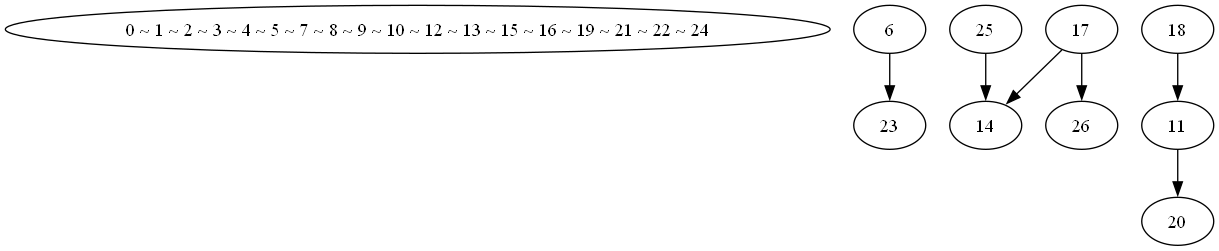

In [24]:
from IPython.display import Image
Image(filename='hasse_diagram.png')

# Reprezentatywna funkcja użyteczności
Do znalezienia reprezentatywnej funkcji użyteczności do metody UTA GMS należy dodać do problemu relacje konieczne i możliwe:
- jeśli zachodzi relacja koniecznej preferencji wariantu $a$ nad $b$ dodajemy:
$$U(a) \ge U(b) + \varepsilon$$
- jeśli nie zachodzi relacja konieczna w żadną stronę:
$$U(a) - U(b)\le  \delta$$
$$U(b) - U(a)\le  \delta$$
gdzie $\delta$ jest minimalizowana
- do zbioru ograniczeń należy także dodać $\varepsilon = \varepsilon^*$

In [25]:
# Znajdowanie reprezentatywnej funkcji użyteczności

eps_opt = value(epsilon) # optymalna wartość epsilon z UTAGMS
prob_cpy = prob.copy() # problem utagms
delta = LpVariable("delta", lowBound=None, upBound=None) # zmienna do minimalizacji

# rozpatrujemy relacje konieczne
# dodajemy do zbioru ograniczeń jeśli (a, b) zachodzi ale nie (b, a): U(a) >= U(b) + epsilon
# dodajemy do zbioru ograniczeń jeśli nie zachodzi ani (a, b) ani (b, a): U(a) - U(b) <= delta oraz U(b) - U(a) <= delta
for a in range(len(data)):
    for b in range(a+1, len(data)):
        if (a, b) in necessary_relations and (b, a) not in necessary_relations: # tylko (a, b) zachodzi koniecznie
            prob_cpy += global_utilities[a] >= global_utilities[b] + epsilon, f"Necessary_relation_{a+1}_over{b+1}"
        elif (b, a) in necessary_relations and (a, b) not in necessary_relations: # tylko (b, a) zachodzi koniecznie
            prob_cpy += global_utilities[b] >= global_utilities[a] + epsilon, f"Necessary_relation_{b+1}_over{a+1}"
        elif (a, b) not in necessary_relations and (b, a) not in necessary_relations: # ani (a, b) ani (b, a) nie zachodzi koniecznie
            prob_cpy += global_utilities[a] - global_utilities[b] <= delta, f"NoNecessary_{a+1}_over{b+1}_1"
            prob_cpy += global_utilities[b] - global_utilities[a] <= delta, f"NoNecessary_{b+1}_over{a+1}_2"

# minimalizujemy deltę - nadpisanie f. celu
prob_cpy += delta, "Minimize_delta"
prob_cpy.sense = LpMinimize

# epsilon równy optymalnej wartości epsilon z UTAGMS
prob_cpy += epsilon == eps_opt, "Epsilon_UTAGMS"
# prob_cpy

c:\Users\jkond\Desktop\studia\ISWD\pulp\lib\site-packages\pulp\pulp.py:1787: UserWarning: Overwriting previously set objective.
  warnings.warn("Overwriting previously set objective.")


#### Wartość funkcji celu

In [26]:
prob_cpy.solve()

# Print results
print(f"Status: {LpStatus[prob_cpy.status]}")
# print("\nOptimal Solution:")
# for var in prob.variables():
#     print(f"{var.name} = {value(var)}")
print("\nObjective value:", value(prob_cpy.objective))


Status: Optimal

Objective value: 0.78787879


#### Użyteczności cząstkowe i globalne wszystkich wariantów

In [27]:
# importy do wykresów
import pandas as pd # wyświetlanie wyników w formie tabeli

In [28]:
lu_values = []
for i, l_utils in enumerate(local_utitlites):
    lu_values.append([value(lu) for lu in l_utils] + [global_utilities[i].value()])
df = pd.DataFrame(lu_values, columns=[f"u_{i+1}" for i in range(len(criterions))] + ["U"])
df.index = [f"x_{i+1}" for i in range(len(data))]
df.index.name = "Warianty"
df.columns.name = "Kryteria"

# pokaż tabelę z użytecznościami lokalnymi
df

Kryteria,u_1,u_2,u_3,u_4,U
Warianty,,,,,
x_1,0.400000,0.100000,0.000000,0.075758,0.575758
x_2,0.400000,0.023242,0.000000,0.100000,0.523242
x_3,0.000000,0.000000,0.000000,0.100000,0.100000
x_4,0.400000,0.023242,0.000000,0.075758,0.499000
x_5,0.400000,0.000000,0.000000,0.100000,0.500000
x_6,0.000000,0.000000,0.000000,0.100000,0.100000
x_7,0.700000,0.087879,0.000000,0.075758,0.863636
x_8,0.400000,0.000000,0.000000,0.100000,0.500000
x_9,0.400000,0.000000,0.000000,0.100000,0.500000


#### Ranking wszystkich wariantów i ich użyteczności globalne

In [29]:
# globalne użyteczności wariantów
gu = np.array([value(gu) for gu in global_utilities])
# [::-1] - sortowanie malejąco
sorted_indices = np.argsort(gu)[::-1] # posortowane indeksy wariantów według użyteczności globalnej
places = np.zeros(len(gu)) # miejsca wariantów

current_place = 1
current_utility = float("inf")
for i, curr in enumerate(sorted_indices):
    util = gu[curr]
    if util != current_utility:
        current_place = i + 1
        current_utility = util
    places[i] = current_place

table = np.vstack((places, sorted_indices,  gu[sorted_indices]))

df = pd.DataFrame(table.T, columns=["Miejsce", "Wariant", "Użyteczność"]).astype({'Miejsce': 'int', 'Wariant': 'int', 'Użyteczność': 'float'})
df.set_index("Miejsce", inplace=True)

df

,Wariant,Użyteczność
Miejsce,,
1,18,0.875758
2,24,0.863636
2,6,0.863636
4,21,0.799000
5,12,0.575758
5,15,0.575758
5,0,0.575758
8,1,0.523242
8,10,0.523242


#### Wykresy

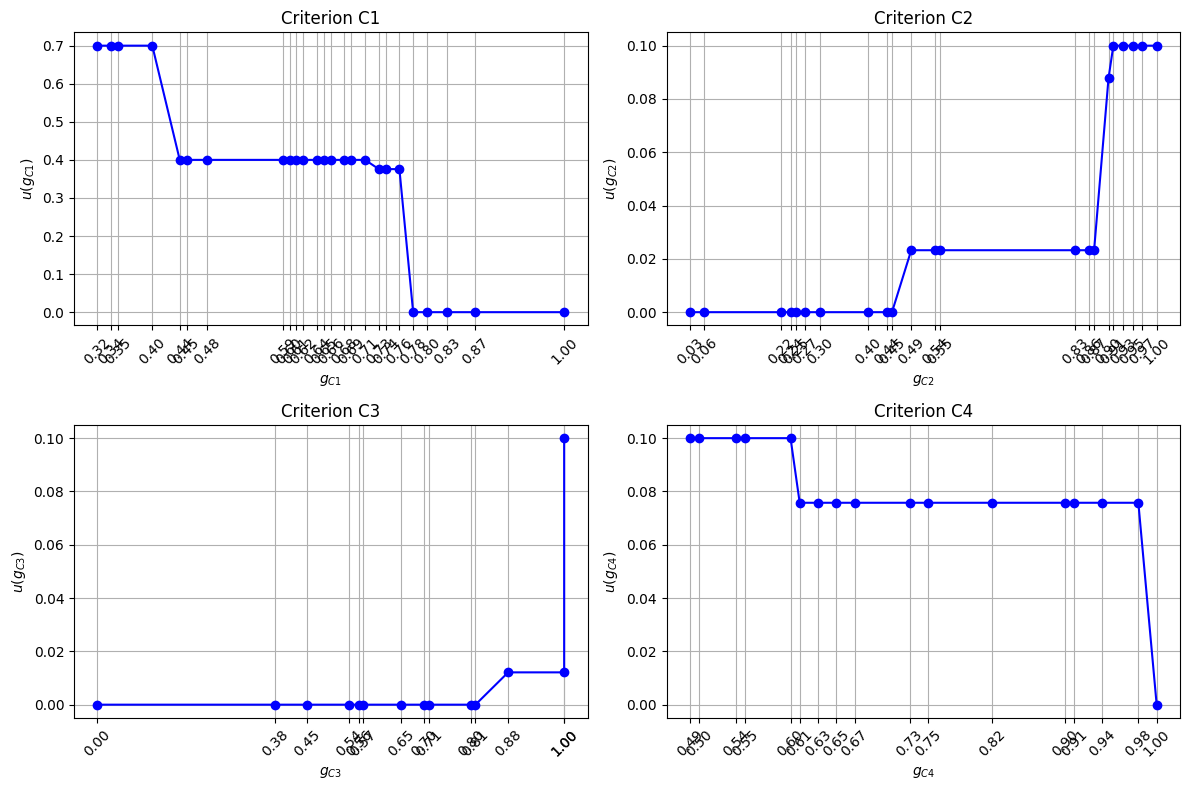

In [30]:
# wykres dla każdego kryterium
# %matplotlib inline

# po 2 wykresy na wiersz
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs = axs.flatten()

for i, ub in enumerate(u_breakpoints):
    criterion = criterions[i]
    args = [bp for bp in breakpoints_sorted[i]]

    values = [value(ub[j]) for j in range(len(ub))]
    max_val, min_val = value(u_b[i]), value(u_a[i])

    # poprawka jeśli skala większa niż wartości wariantów na kryterium
    if max_val not in values:
        if criterion_directions[i] == "gain":
            args = args + [max_values[i]]
            values = values + [max_val]
        if criterion_directions[i] == "cost":
            args = [min_values[i]] + args
            values = [max_val] + values
    if min_val not in values:
        if criterion_directions[i] == "gain":
            args = [min_values[i]] + args
            values = [min_val] + values
        if criterion_directions[i] == "cost":
            args = args + [max_values[i]]
            values = values + [min_val]

    axs[i].plot(args, values, marker='o', linestyle='-', color='b', label=f"$u(g_{criterion})$")
    axs[i].set_title(f"Criterion {criterions[i]}")
    axs[i].set_xlabel(f"$g_{{{criterion}}}$")
    axs[i].set_ylabel(f"$u(g_{{{criterion}}})$")
    axs[i].set_xticks(args)
    axs[i].tick_params(axis='x', rotation=45)
    axs[i].grid(True)

plt.tight_layout()
plt.show()

Wyniki podobne do wyników UTA, jeśli chodzi o ważność kryterium 1 - tu też ma największą wagę. Jednakże najmniejszy wpływ zdaje się mieć kryterium 3, które w UTA miało dwukrotnie większą wagę niż 2 i 4 - tutaj wszystkie mają 0.1, oraz większość wariantów ma na nim użyteczność 0.

Dół rangingu dalej dominują warianty o planie finansowym $F_3$ (6 ostatnich). Lepiej odwzorowana została preferencja wariantów o planie finansowym $F_1$ - pierwsze 7 wariantów w rankingu ją posiada. Zmieniły się warianty najlepsze i najgorsze. Najlepsza 24 spadła na 2-gą pozycję, a najgorsza 2 wzniosła się na 4-te miejsce od końca. Na ich miejsce wskoczyły kolejno 18 i 20.

Analizując przykładowe warianty niereferencyjne - takie same jak przy UTA:

- 3, 4, 5 - Różnią się jedynie planami finansowymi (kolejno $F_1, F_2, F_3$). Taka sama sytuacja jak w UTA: preferencja decydenta nie została zachowana częściowo, warianty są w rankingu w kolejności $4>3>5$, $F_2$ zostało wybrane ponad $F_1$. Podanie więcej wariantów referencyjnych pomogłoby lepiej odwzorować preferencje decydenta.
Bardzo dobrze jednak odwzorowano preferencję mówiącą o tym, że najmniej preferujemy plan finansowy $F_3$ - ostatnie 6 wariantów w rankingu go używa.\
- 3, 12, 21 - Różnią się jedynie planami przechowywania (kolejno $S_1, S_2, S_3$). Ich kolejność w rankingu to $21>12>3$. W porównaniu z UTA w któreym preferenacja decydenta została odwzorowana częściowo tutaj jest zupełnie odwrotna.

Co ciekawe wartość delty jest bardzo wysoka - zapewne wysoka wartość epsilon wymusiła do preferowania wariantów o niskiej wartości kryterium 1, co z kolei sprawiło, że różnice na wariantach które mocno się różniły na tym kryterium, a 1 nie był preferowany nad drugi są tak wysokie. Choć niepokoić może wyższa wartość delty od epsilon.

Ranking referencyjny zachowany. Napawać niepokojem może również dużo remisów - szczególnie w środku rankingu - ciężko określić które lepsze.

3 z 4 kryteriów zdają się mieć w przybliżeniu 3-4 punkty przełamania funkcji liniowej - zatem zwykła UTA też byłaby w stanie je dość dobrze odwzorować.